### Acknowledgement

Some of the code in this baseline model consulted the `discussion.ipynb` file provided. The file is originated from CSE 151B Discussion Week 7, Spring 2022.

## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def transform_data(np_data, bch_id):
    df = pd.DataFrame(np_data[bch_id], columns = ['x','y'])
    df['x_vel'] = np.gradient(df.x)
    df['y_vel'] = np.gradient(df.y)
    df['vel'] = np.sqrt(df.x_vel**2 + df.y_vel**2)
    df['x_acc'] = np.gradient(df.x_vel)
    df['y_acc'] = np.gradient(df.y_vel)
    df['acc'] = np.gradient(df.vel)
    tangent = np.array([1/df.vel]*2).T * np.array([df.x_vel, df.y_vel]).T
    df['curvature'] = np.abs(df.x_acc * df.y_vel - df.x_vel * df.y_acc) / (df.vel)**3
    out = df[['x', 'y', 'curvature']]
    return out.to_numpy()


def rotate(X, startpoint, endpoint, default_angle):
    
    # Find the slope of the path
    dx = X[:, endpoint, 0] - X[:, startpoint, 0]
    dy = X[:, endpoint, 1] - X[:, startpoint, 1]
    
    # Convert theta to degree in the range(0, 360)
    theta = np.arctan2(dy, dx)
    angle = np.degrees(theta)
    angle[angle < 0] += 360
    
    # Generate the degree we want to rotate by and convert back to theta
    rotate_degree = -1 * (angle - default_angle)
    rotate_theta = np.deg2rad(rotate_degree)
    
    # Reshape the array from [4, batchsize] to [batchsize, 2, 2]
    rot = np.array([np.cos(rotate_theta), -np.sin(rotate_theta),
                np.sin(rotate_theta), np.cos(rotate_theta)])
    rot = rot.T.reshape(-1, 2, 2)
    
    return rot


def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None, normalized=False):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.normalized = normalized
        self.split = split

        self.inputs, self.outputs = self.get_city_trajectories(city=city, split=split)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.split == 'train':
        
            data = (self.inputs[idx], self.outputs[idx])

#             if self.transform:
#                 data = self.transform(data)

            return data
        
        return self.inputs[idx]
    
    def get_city_trajectories(self, city="palo-alto", split="train"):
        assert city in cities and split in splits

        # get input
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)

        # store input starting positions and rotation matrix
        start_pos = inputs[:, 0, :].copy()
        rotate_factor = rotate(inputs, 0, 29, 30)

        # normalize inputs (translation + rotation)
        if self.normalized:
            for i in range(len(inputs)):
                inputs[i] -= start_pos[i, :]
                
            for i in range(len(inputs)):
                inputs[i] = inputs[i] @ rotate_factor[i].T

        # get output
        outputs = None
        if split == "train":  # get and normalize outputs
            f_out = ROOT_PATH + split + "/" + city + "_outputs"
            outputs = pickle.load(open(f_out, "rb"))
            outputs = np.asarray(outputs)
            if self.normalized:
                for i in range(len(inputs)):
                    outputs[i] -= start_pos[i, :]
                    
                for i in range(len(inputs)):
                    outputs[i] = outputs[i] @ rotate_factor[i].T
                    
            # Adding curvature as features
            if self.transform:
#                 print(inputs.shape)
#                 print(outputs.shape)
                inputs = np.array([transform_data(inputs, i) for i in range(len(inputs))])
                print(inputs.shape)

        self.start_pos = start_pos
        self.rotate_matrix = rotate_factor # np.linalg.inv(rot[i].T) to reverse back

        return inputs, outputs


In [3]:
# intialize a dataset
city = 'palo-alto' 
split = 'train' #'test' #'train'
train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)

len(train_dataset)

11993

In [4]:
# intialize a dataset
city = 'palo-alto' 
split = 'train' #'test' #'train'
train_orig = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)

len(train_orig)

11993

## Create a DataLoader class for training

In [5]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset, batch_size=batch_sz, drop_last=True)
comparison_loader = DataLoader(train_orig, batch_size=batch_sz, drop_last=True)

In [6]:
len(train_loader), len(comparison_loader)

(2998, 2998)

In [7]:
for inp, out in train_loader:
    print(inp.shape)
    print(out.shape)
    for bs in range(len(inp)):
        print(len(inp[bs]))
        print(len(out[bs]))
        x = inp
        y = out
        break
    break

# # FOR TEST SET
# for inp in train_loader:
#     for bs in range(len(inp)):
#         print(inp.shape)
#         print(len(inp[bs]))
#         print(inp[0][:5])
#         break
#     break

torch.Size([4, 50, 2])
torch.Size([4, 60, 2])
50
60


In [10]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=.5)
    axs = axs.ravel()   
    for i in range(4):
        axs[i].xaxis.set_ticks([inp[i,0,0],
                                   inp[i,-1,0], out[i,-1,0]])
        axs[i].yaxis.set_ticks([inp[i,0,1],
                                   inp[i,-1,1], out[i,-1,1]])

        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])



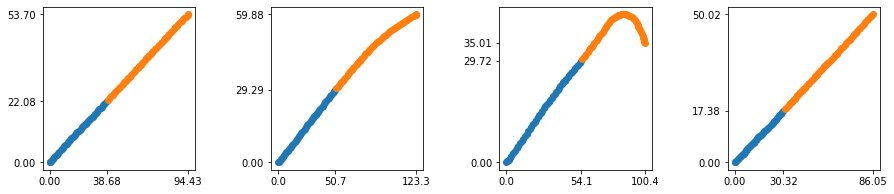

In [11]:
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    show_sample_batch(sample_batch)
    inp = inp.numpy()
    out = out.numpy()
    break

In [12]:
for inp, out in comparison_loader:
    for bs in range(len(inp)):
        x = inp.numpy()
        y = out.numpy()
        break
    break

rot = rotate(x, 0, 29, 30)
rot

array([[[ 0.88875498,  0.45838259],
        [-0.45838259,  0.88875498]],

       [[-0.46170034,  0.88703596],
        [-0.88703596, -0.46170034]],

       [[-0.4281046 ,  0.90372919],
        [-0.90372919, -0.4281046 ]],

       [[-0.92272612, -0.38545624],
        [ 0.38545624, -0.92272612]]])

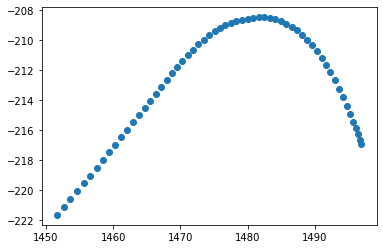

In [13]:
after = (y[2]@rot[2].T)
plt.scatter(after[:, 0], after[:, 1])

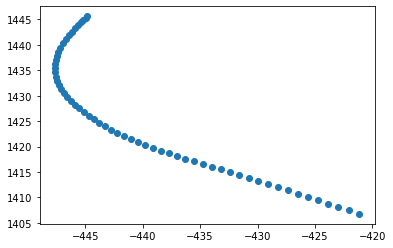

In [14]:
convert = after@np.linalg.inv(rot[2].T)
plt.scatter(convert[:, 0], convert[:, 1])

## Sample a batch of data and visualize 

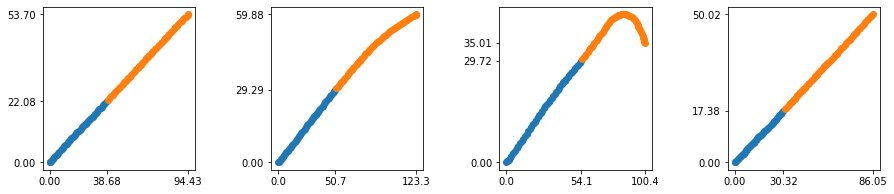

In [15]:
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

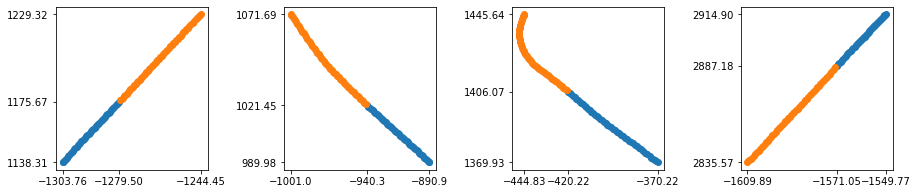

In [16]:
for i_batch, sample_batch in enumerate(comparison_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

## Create a AutoEncoder Model for training

In [17]:
class MLP(nn.Module):
    """
    Baseline Model: Fully-Connected Feed-Forward
    Input: 50 x (x, y) = 50 x 2
    Output: 60 x (x, y) = 60 x 2
    """
    
    def __init__(self, hidden_dim=64, input_dim=2, output_dim=120, batch_size=16):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.batch_size = batch_size

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # encoder Shape: [batch, 50, hidden_dim]
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # interpreter [batch, 50, hidden_dim]
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), # [batch, 50, hidden_dim]
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), # [batch, 50, hidden_dim]
            nn.ReLU()
        )
        
        # After Reshape [batch, hidden_dim*50]

        self.decode = nn.Sequential(
            nn.Linear(hidden_dim*50, hidden_dim*20),  # decoder  [batch, hidden_dim]
            nn.ReLU(),
            nn.Linear(hidden_dim*20, hidden_dim),  # interpreter [batch, hidden_dim]
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim) # [batch, output_dim]
        )
        
        self.init_weights()
        
#         nn.Linear(hidden_dim * 50, output_dim)
    
    def forward(self, X):
        step = self.encoder(X)
        step = step.reshape(self.batch_size, -1)
        return self.decode(step)

    def predict(self, X):
        pass
    
    def init_weights(self):
        for m in self.modules():
#             print(m)
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [19]:
def fit(city, split, transform=False, normalized=True, batch_size=32,
        hidden_dim=128, input_dim=2, output_dim=120, learning_rate=0.01, num_iters=50):
    
    # Create train test sets
    train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)
    train_sz = int(len(train_dataset) * 0.9)
    val_sz = len(train_dataset) - train_sz
    train_loader, val_loader = torch.utils.data.random_split(train_dataset, [train_sz, val_sz])
    train_loader = DataLoader(train_loader, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_loader, batch_size=batch_size, drop_last=True)

    # initialize model
    model = MLP(hidden_dim=hidden_dim, input_dim=input_dim, 
                output_dim=output_dim, batch_size=batch_size).to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5)
    
    # initiate trackers
    avg_train_loss, avg_val_loss = [], []
    train_time, elapsed_time = [], []
    # prev_avg_val, best_val_score = float('inf'), float('inf')
    best_train_score = float('inf')
    val_increase_num = 0

    # train epoch
    for epoch in tqdm(list(range(num_iters))):
        print(f'Epoch {epoch+1}')
        print('Training & Validating ', end='')

        start_time = time.time()
        train_loss, val_loss = [], []

        # train a batch
        for batches, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            # track progress
            if (batches + 1) % 20 == 0:
                print('-', end='')

            # train
            optimizer.zero_grad()                 # clear gradient
            output = model(X.float())                     # forward pass

    #         print(y.shape)
    #         print(output.shape)

            loss = loss_function(output, y.reshape(batch_size, -1).float())   # compute loss
            loss.backward()                       # backward pass: gradient
            optimizer.step()                      # update parameter
            train_loss.append(loss.item())        # loss value for 1 batch

        print()
        avg_train = np.mean(train_loss)
        avg_train_loss.append(avg_train)

        end_train_time = time.time()
        train_time.append(end_train_time - start_time)

        # save better model
#         if avg_train < best_train_score:
#             best_train_score = avg_train
#             torch.save(model, 'best_overfit.pt')
#             print('- Model Saved')

        # validation
        with torch.no_grad():

            for batches, (X, y) in enumerate(val_loader):
                X = X.to(device)
                y = y.to(device)
            
                output = model(X.float())
                loss = loss_function(output, y.reshape(batch_size, -1).float())
                val_loss.append(loss.item())

            avg_val = np.mean(val_loss)
            avg_val_loss.append(avg_val)

    # #     # save better model
    # #     if avg_val < best_val_score:
    # #         best_val_score = avg_val
    # #         torch.save(model.state_dict(), 'best_overfit.pt')

        end_time = time.time()
        elapsed_time.append(end_time - start_time)

        print(f'- Training Loss: {avg_train}\n- Validation Loss: {avg_val}')
        print(f'- Train Time: {sum(train_time)}\n- Elapsed Time: {sum(elapsed_time)}\n')
        
        scheduler.step(avg_val)

#         # early stop
#         if avg_val > prev_avg_val:
#             val_increase_num += 1
#         else:
#             val_increase_num = 0
#         prev_avg_val = avg_val
#         if val_increase_num >= 5:
#             print('EARLY STOPPING INITIATED...')
#             break
    
    return model, (avg_train_loss, avg_val_loss)

In [23]:
city = 'palo-alto' 
split = 'train' #'test' #'train'
batch_size = 32
hidden_dim = 64
num_iters = 100
palo_train_mod, losses = fit(city=city, split=split, batch_size=batch_size,
                            hidden_dim=hidden_dim, num_iters=num_iters)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
Training & Validating ----------------
- Training Loss: 181.70109817323768
- Validation Loss: 127.70834804225612
- Train Time: 1.25958251953125
- Elapsed Time: 1.2970771789550781

Epoch 2
Training & Validating ----------------
- Training Loss: 105.7579814899569
- Validation Loss: 122.46295413455448
- Train Time: 2.801421642303467
- Elapsed Time: 2.875170946121216

Epoch 3
Training & Validating ----------------
- Training Loss: 103.3312622885322
- Validation Loss: 109.97482093604836
- Train Time: 4.480900049209595
- Elapsed Time: 4.624350309371948

Epoch 4
Training & Validating ----------------
- Training Loss: 71.03532915087058
- Validation Loss: 67.12677991712415
- Train Time: 6.017111539840698
- Elapsed Time: 6.197236061096191

Epoch 5
Training & Validating ----------------
- Training Loss: 50.888037395760286
- Validation Loss: 46.516218391624655
- Train Time: 7.549373149871826
- Elapsed Time: 7.767030715942383

Epoch 6
Training & Validating ----------------
- Training Loss: 

In [30]:
def plot_loss(start_from, city, split, losses):

    avg_train_loss, avg_val_loss = losses
    plt.plot(np.sqrt(avg_train_loss[start_from:]), label='train_loss')
    plt.plot(np.sqrt(avg_val_loss[start_from:]), label='validation_loss')
    plt.title(f'{city} RMSE {split} Loss vs. Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

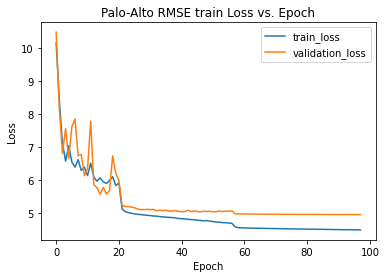

In [31]:
plot_loss(2, 'Palo-Alto', 'train', losses)

In [39]:
def vis_results(city, split, batch_size, model, idx):
    train_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    model.cpu()
    
    with torch.no_grad():
        for (X, y) in train_loader:
            X = X.cpu()
            y = y.cpu()
            output = model(X.float().cpu()).reshape(batch_size, -1, 2).cpu()
            break
    
    print(X.shape)
    print(y.shape)
    print(output.shape)
    
    x_jump = train_dataset.start_pos[idx, 0]
    y_jump = train_dataset.start_pos[idx, 0]
    rot = train_dataset.rotate_matrix[idx].T
    X = X[idx] @ np.linalg.inv(rot) + train_dataset.start_pos[idx]
    y = y[idx] @ np.linalg.inv(rot) + train_dataset.start_pos[idx]
    output = output[idx] @ np.linalg.inv(rot) + train_dataset.start_pos[idx]
    
    plt.scatter(X[:, 0], X[:, 1], label='seed')
    plt.scatter(y[:, 0], y[:, 1], label='ground truth')
    plt.scatter(output[:, 0], output[:, 1], label='prediction')
    plt.title(f'Random Sample From {city}_{split} Projectile Visualization')
    plt.legend()
    plt.show()
        

torch.Size([32, 50, 2])
torch.Size([32, 60, 2])
torch.Size([32, 60, 2])


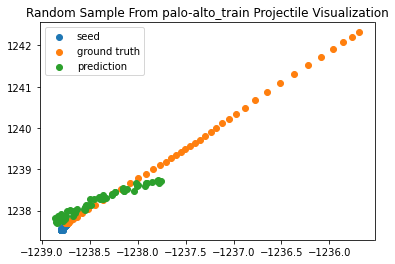

In [40]:
vis_results('palo-alto', 'train', 32, palo_train_mod, 16)

## Train models for other cities

### austin
- best KAGGLE val loss: 31.061992844538903
- best val loss: 21.4315324826027

In [34]:
city = 'austin' 
split = 'train' #'test' #'train'
batch_size = 32
hidden_dim = 64
num_iters = 100
austin_train_mod, austin_losses = fit(city=city, split=split, hidden_dim=hidden_dim,
                                      batch_size=batch_size, num_iters=num_iters)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
Training & Validating ------------------------------------------------------------
- Training Loss: 89.69602610690535
- Validation Loss: 42.500753616219136
- Train Time: 9.687225818634033
- Elapsed Time: 9.86424994468689

Epoch 2
Training & Validating ------------------------------------------------------------
- Training Loss: 42.96211491892161
- Validation Loss: 37.37696472566519
- Train Time: 17.131022930145264
- Elapsed Time: 17.473789930343628

Epoch 3
Training & Validating ------------------------------------------------------------
- Training Loss: 40.31700306648065
- Validation Loss: 34.458844761350264
- Train Time: 22.81644582748413
- Elapsed Time: 23.278975009918213

Epoch 4
Training & Validating ------------------------------------------------------------
- Training Loss: 37.16654974488188
- Validation Loss: 35.11411406388923
- Train Time: 28.514603853225708
- Elapsed Time: 29.100958347320557

Epoch 5
Training & Validating --------------------------------------------

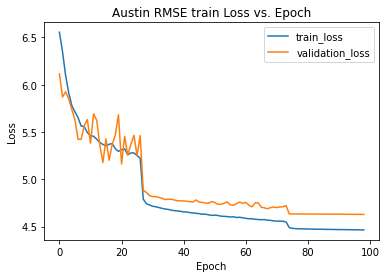

In [52]:
plot_loss(1, 'Austin', 'train', austin_losses)

torch.Size([32, 50, 2])
torch.Size([32, 60, 2])
torch.Size([32, 60, 2])


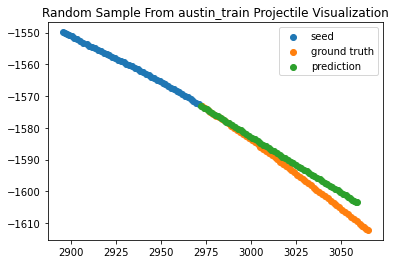

In [41]:
vis_results('austin', 'train', 32, austin_train_mod, 23)

In [42]:
# intialize a dataset
city = 'austin' 
split = 'test' 
test_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)   
temp_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)   
print(len(test_dataset)) # SHOULD BE 6325

# test_dataset.start_pos

batch_sz = 32  # batch size 
test_loader = DataLoader(test_dataset, batch_size=batch_sz)
temp_loader = DataLoader(temp_dataset, batch_size=batch_sz)
austin_train_mod.to('cpu')
len(test_loader), len(temp_loader)

6325


(198, 198)

In [43]:
def vis_test(idx, transform=True):
    '''
    This is the last batch, which is usually not complete and need to fill with 0s.
    Check if I convert the prediction back correctly or not
    '''
    for X in test_loader:
        if len(X) == batch_sz:
            continue
        print(len(X))
        to_fill = np.zeros([batch_sz-len(X), 50, 2])
        X = torch.from_numpy(np.append(X, to_fill, axis=0)).float()
        X = X.cpu().float()
        pred = austin_train_mod(X)
        pred = pred.reshape(batch_sz, -1, 2).cpu().detach().numpy()
        
        if not transform:
            plt.scatter(X[idx, :, 0], X[idx, :, 1], label='input')
            plt.scatter(pred[idx, :, 0], pred[idx, :, 1], label='pred')
            plt.legend()
            plt.show()
        else:
            rotation =  test_dataset.rotate_matrix[-1].T
            X[idx] = X[idx] @ np.linalg.inv(rotation)
            X[idx] = X[idx] + test_dataset.start_pos[-1, : ]
            pred[idx] = pred[idx] @ np.linalg.inv(rotation)
            pred[idx] = pred[idx] + test_dataset.start_pos[-1, : ]

            plt.scatter(X[idx, :, 0], X[idx, :, 1], label='input')
            plt.scatter(pred[idx, :, 0], pred[idx, :, 1], label='pred')
            plt.legend()
            plt.show()
    

21


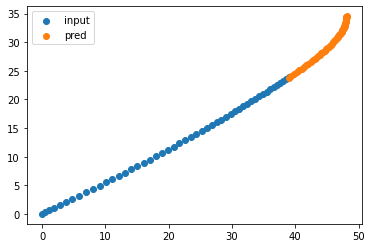

In [44]:
vis_test(20, False)

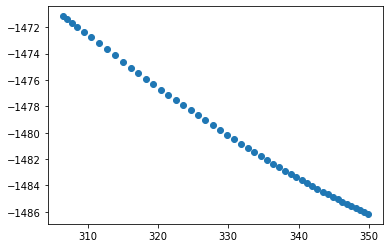

In [45]:
for X in temp_loader:
    if len(X) == batch_sz:
        continue
    # the index here should refer to the above cell's number
    plt.scatter(X[20, :, 0], X[20, :, 1], label='input')
    plt.legend
    plt.show()

21


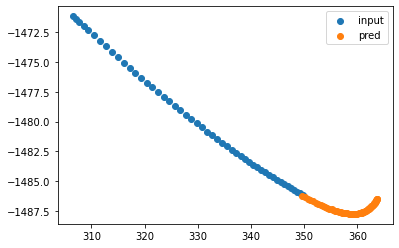

In [46]:
vis_test(20, True)

In [47]:
def make_pred(test_loader, batch_sz, model):
    '''
    Remember to use test_dataset stats, NOT train_dataset
    '''
    count_row = 0
    out = []

    for X in test_loader:
        X = X.cpu().float()
        if len(X) != batch_sz:
            print(len(X))
            to_fill = np.zeros([batch_sz-len(X), 50, 2])
            X = torch.from_numpy(np.append(X, to_fill, axis=0)).float()
            
#             a = test_dataset.rotate_matrix[-1].T
#             temp = X[20]@np.linalg.inv(a) + test_dataset.start_pos[-1]
#             plt.scatter(temp[:, 0], temp[:, 1], label='input')

        pred = model(X)
        pred = pred.reshape(batch_sz, -1, 2).cpu().detach().numpy()
        for i in range(batch_sz):
            if count_row >= len(test_dataset):
                break
                
#             if count_row == (len(test_dataset) - 1):
#                 plt.scatter(X[i, :, 0], X[i, :, 1], label='input')
#                 plt.scatter(pred[i, :, 0], pred[i, :, 1], label='pred')
#                 plt.legend()
#                 plt.show()

            rotation =  test_dataset.rotate_matrix[count_row].T
            pred[i] = pred[i] @ np.linalg.inv(rotation)
            pred[i] = pred[i] + test_dataset.start_pos[count_row, : ]

    #         print(pred[i, 0, :])
                
            out.append(pred[i])
            count_row += 1 
            
    #         print(count_row)
    #         print(pred[0, :5, :])

    out = np.array(out).reshape(len(test_dataset), -1)

    return out


In [48]:
austin_array = make_pred(test_loader, batch_sz, austin_train_mod)
austin_array.shape

21


(6325, 120)

In [49]:
austin_array[6324, -2:]

array([  363.7334, -1486.4718], dtype=float32)

In [50]:
# idx=6324
# a = test_dataset.start_pos[idx, 0]
# b = test_dataset.start_pos[idx, 1]
# plt.scatter(X[idx-6272, :, 0]+a,
#             X[idx-6272, :, 1]+b, label='seed')
# # plt.scatter(y[idx, :, 0], y[idx, :, 1], label='ground truth')
# plt.scatter(pred[idx-6272, :, 0], pred[idx-6272, :, 1], label='prediction')
# plt.legend()
# plt.show()

### miami
- best KAGGLE val loss: 24.166294670104982
- best val loss: 18.53021953259295

In [51]:
city = 'miami' 
split = 'train' #'test' #'train'
batch_size = 32
hidden_dim = 64
num_iters = 100
learning_rate = 0.01
miami_train_mod, miami_losses = fit(city=city, split=split, batch_size=batch_size,
                                    hidden_dim=hidden_dim, learning_rate=learning_rate,
                                    num_iters=num_iters)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
Training & Validating -----------------------------------------------------------------------------
- Training Loss: 83.25551618293709
- Validation Loss: 65.95937818114521
- Train Time: 11.035842895507812
- Elapsed Time: 11.289653301239014

Epoch 2
Training & Validating -----------------------------------------------------------------------------
- Training Loss: 65.92275670057123
- Validation Loss: 63.416712643807394
- Train Time: 21.206794261932373
- Elapsed Time: 21.660753965377808

Epoch 3
Training & Validating -----------------------------------------------------------------------------
- Training Loss: 63.226445281898584
- Validation Loss: 61.46928233988801
- Train Time: 30.42730450630188
- Elapsed Time: 31.072884559631348

Epoch 4
Training & Validating -----------------------------------------------------------------------------
- Training Loss: 55.55032601199307
- Validation Loss: 38.78792406383314
- Train Time: 40.453447580337524
- Elapsed Time: 41.36046314239502

Epoc

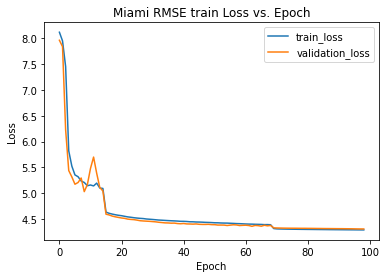

In [54]:
plot_loss(1, 'Miami', 'train', miami_losses)

torch.Size([32, 50, 2])
torch.Size([32, 60, 2])
torch.Size([32, 60, 2])


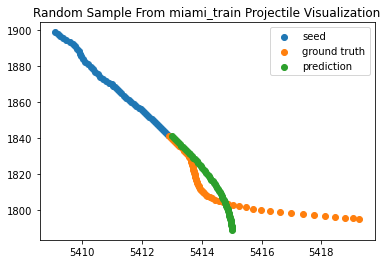

In [57]:
vis_results('miami', 'train', 32, miami_train_mod, 31)

In [58]:
# intialize a dataset
city = 'miami' 
split = 'test' 
test_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)
temp_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)
print(len(test_dataset)) # should be 7971

# test_dataset.start_pos

batch_sz = 32  # batch size 
test_loader = DataLoader(test_dataset, batch_size=batch_sz)
temp_loader = DataLoader(temp_dataset, batch_size=batch_sz)
miami_train_mod.to('cpu')
len(test_loader), len(temp_loader)

7971


(250, 250)

3


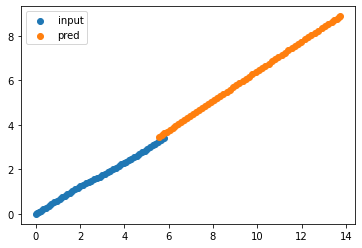

In [59]:
vis_test(2, False)

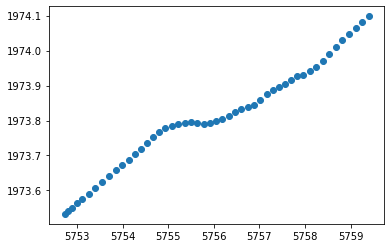

In [60]:
for X in temp_loader:
    if len(X) == batch_sz:
        continue
    # the index here should refer to the above cell's number
    plt.scatter(X[2, :, 0], X[2, :, 1], label='input')
    plt.legend
    plt.show()

3


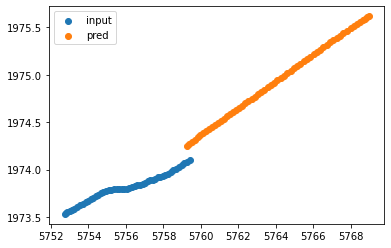

In [61]:
vis_test(2, True)

In [62]:
miami_array = make_pred(test_loader, batch_sz, miami_train_mod)
miami_array.shape

3


(7971, 120)

### pittsburgh
- best KAGGLE val loss: 24.98648140710943
- best val loss: 18.70769113302231

In [63]:
city = 'pittsburgh' 
split = 'train' #'test' #'train'
batch_size = 32
hidden_dim = 32
num_iters = 100
pittsburgh_train_mod, pittsburgh_losses = fit(city=city, split=split,
                                              hidden_dim=hidden_dim, batch_size=batch_size, num_iters=num_iters)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
Training & Validating -------------------------------------------------------------
- Training Loss: 72.27043764419805
- Validation Loss: 35.605763126822076
- Train Time: 5.825195550918579
- Elapsed Time: 5.952212810516357

Epoch 2
Training & Validating -------------------------------------------------------------
- Training Loss: 37.98031718356937
- Validation Loss: 32.999563567778644
- Train Time: 13.184351205825806
- Elapsed Time: 13.533328533172607

Epoch 3
Training & Validating -------------------------------------------------------------
- Training Loss: 34.97380641083312
- Validation Loss: 31.8451889963711
- Train Time: 18.82474422454834
- Elapsed Time: 19.355647325515747

Epoch 4
Training & Validating -------------------------------------------------------------
- Training Loss: 32.22329083533069
- Validation Loss: 26.28345025988186
- Train Time: 24.341465950012207
- Elapsed Time: 25.068140506744385

Epoch 5
Training & Validating ----------------------------------------

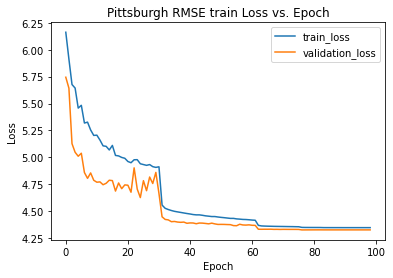

In [64]:
plot_loss(1, 'Pittsburgh', 'train', pittsburgh_losses)

torch.Size([32, 50, 2])
torch.Size([32, 60, 2])
torch.Size([32, 60, 2])


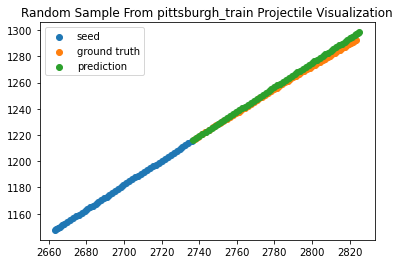

In [67]:
vis_results('pittsburgh', 'train', 32, pittsburgh_train_mod, 29)

In [68]:
# intialize a dataset
city = 'pittsburgh' 
split = 'test' 
test_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)
temp_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)
print(len(test_dataset)) # should be 6361

# test_dataset.start_pos

batch_sz = 32  # batch size 
test_loader = DataLoader(test_dataset, batch_size=batch_sz)
temp_loader = DataLoader(temp_dataset, batch_size=batch_sz)
pittsburgh_train_mod.to('cpu')
len(test_loader)

6361


199

25


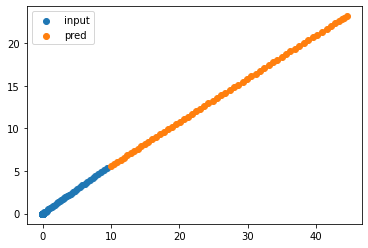

In [69]:
vis_test(24, False)

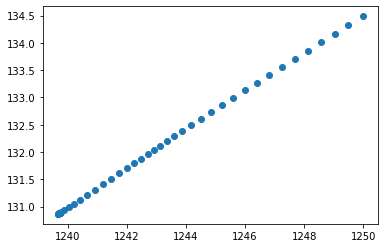

In [70]:
for X in temp_loader:
    if len(X) == batch_sz:
        continue
    # the index here should refer to the above cell's number
    plt.scatter(X[24, :, 0], X[24, :, 1], label='input')
    plt.legend
    plt.show()

25


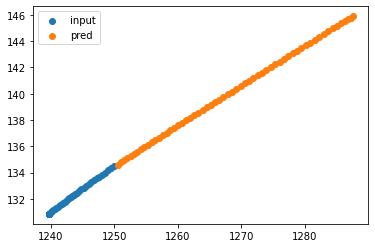

In [71]:
vis_test(24, True)

In [72]:
pittsburgh_array = make_pred(test_loader, batch_sz, pittsburgh_train_mod)
pittsburgh_array.shape

25


(6361, 120)

### dearborn
- best KAGGLE val loss: 31.318197677009984
- best val loss: 24.707670839209307

In [73]:
city = 'dearborn' 
split = 'train' #'test' #'train'
hidden_dim = 64
batch_size = 32
num_iters = 100
dearborn_train_mod, dearborn_losses = fit(city=city, split=split,
                                          hidden_dim=hidden_dim, batch_size=batch_size, num_iters=num_iters)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
Training & Validating ----------------------------------
- Training Loss: 137.69318099077358
- Validation Loss: 83.16420148548328
- Train Time: 4.47907829284668
- Elapsed Time: 4.62790322303772

Epoch 2
Training & Validating ----------------------------------
- Training Loss: 88.74421048996061
- Validation Loss: 81.21725667150397
- Train Time: 8.05974817276001
- Elapsed Time: 8.279291152954102

Epoch 3
Training & Validating ----------------------------------
- Training Loss: 84.68792486468027
- Validation Loss: 79.5470225936488
- Train Time: 11.087214231491089
- Elapsed Time: 11.381314516067505

Epoch 4
Training & Validating ----------------------------------
- Training Loss: 83.30840670508007
- Validation Loss: 80.39799918626484
- Train Time: 15.154445171356201
- Elapsed Time: 15.580195188522339

Epoch 5
Training & Validating ----------------------------------
- Training Loss: 82.30743777890538
- Validation Loss: 88.69840150130422
- Train Time: 17.979968547821045
- Elapsed Tim

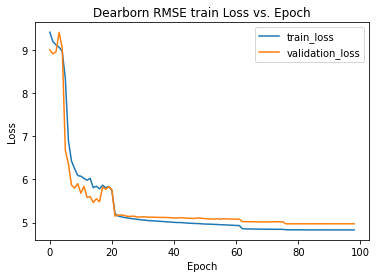

In [74]:
plot_loss(1, 'Dearborn', 'train', dearborn_losses)

torch.Size([32, 50, 2])
torch.Size([32, 60, 2])
torch.Size([32, 60, 2])


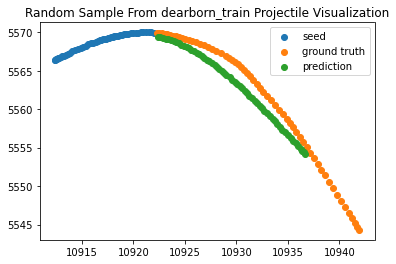

In [77]:
vis_results('dearborn', 'train', 32, dearborn_train_mod, 0)

In [78]:
# intialize a dataset
city = 'dearborn' 
split = 'test' 
test_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)
temp_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)
print(len(test_dataset)) # should be 3671

# test_dataset.start_pos

batch_sz = 32  # batch size 
test_loader = DataLoader(test_dataset, batch_size=batch_sz)
temp_loader = DataLoader(temp_dataset, batch_size=batch_sz)
dearborn_train_mod.to('cpu')
len(test_loader)

3671


115

23


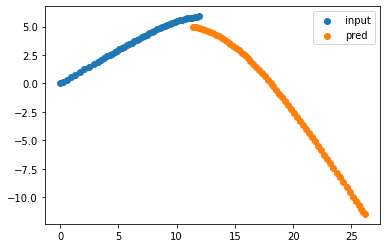

In [79]:
vis_test(22, False)

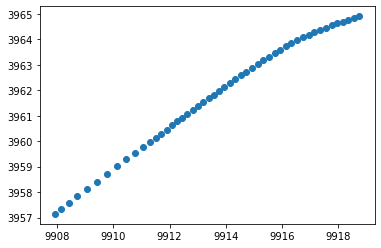

In [80]:
for X in temp_loader:
    if len(X) == batch_sz:
        continue
    # the index here should refer to the above cell's number
    plt.scatter(X[22, :, 0], X[22, :, 1], label='input')
    plt.legend
    plt.show()

23


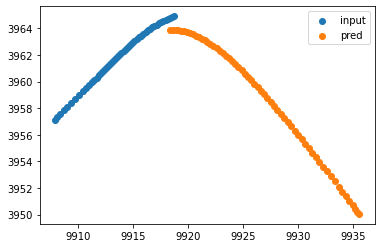

In [81]:
vis_test(22, True)

In [82]:
dearborn_array = make_pred(test_loader, batch_sz, dearborn_train_mod)
dearborn_array.shape

23


(3671, 120)

### washington-dc
- best KAGGLE val loss: 28.915434670448303
- best val loss: 21.85133969783783 (could be better ~21.1)

In [87]:
city = 'washington-dc' 
split = 'train' #'test' #'train'
hidden_dim = 128
batch_size = 32
num_iters = 100
washington_train_mod, washington_losses = fit(city=city, split=split,
                                              hidden_dim=hidden_dim, batch_size=batch_size, num_iters=num_iters)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
Training & Validating ------------------------------------
- Training Loss: 279.09086294068817
- Validation Loss: 61.879762613773345
- Train Time: 5.101280689239502
- Elapsed Time: 5.188570499420166

Epoch 2
Training & Validating ------------------------------------
- Training Loss: 68.38796791582476
- Validation Loss: 111.836683177948
- Train Time: 9.68432092666626
- Elapsed Time: 9.849931001663208

Epoch 3
Training & Validating ------------------------------------
- Training Loss: 67.57212781642681
- Validation Loss: 72.90643620491028
- Train Time: 14.447901964187622
- Elapsed Time: 14.689737558364868

Epoch 4
Training & Validating ------------------------------------
- Training Loss: 65.06190559482047
- Validation Loss: 58.37341730594635
- Train Time: 19.22600817680359
- Elapsed Time: 19.556092739105225

Epoch 5
Training & Validating ------------------------------------
- Training Loss: 62.805628573696914
- Validation Loss: 79.37635073661804
- Train Time: 23.61782479286194
-

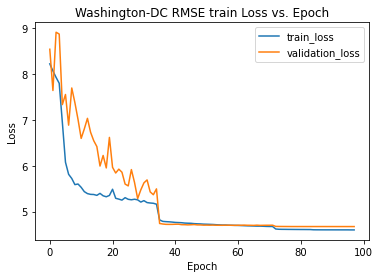

In [89]:
plot_loss(2, 'Washington-DC', 'train', washington_losses)

torch.Size([32, 50, 2])
torch.Size([32, 60, 2])
torch.Size([32, 60, 2])


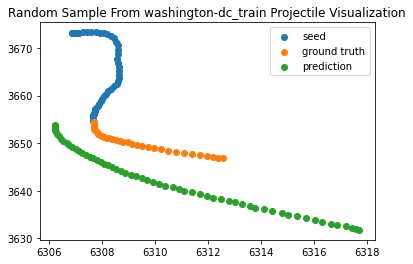

In [90]:
vis_results('washington-dc', 'train', 32, washington_train_mod, 30)

In [91]:
# intialize a dataset
city = 'washington-dc' 
split = 'test' 
test_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)
temp_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)
print(len(test_dataset)) # should be 3829

# test_dataset.start_pos

batch_sz = 32  # batch size 
test_loader = DataLoader(test_dataset, batch_size=batch_sz)
temp_loader = DataLoader(temp_dataset, batch_size=batch_sz)
washington_train_mod.to('cpu')
len(test_loader)

3829


120

21


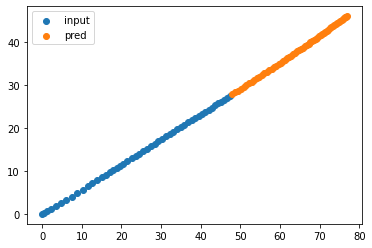

In [92]:
vis_test(20, False)

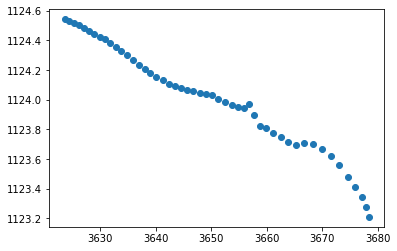

In [93]:
for X in temp_loader:
    if len(X) == batch_sz:
        continue
    # the index here should refer to the above cell's number
#     print(X[20])
    plt.scatter(X[20, :, 0], X[20, :, 1], label='input')
    plt.legend
    plt.show()

21


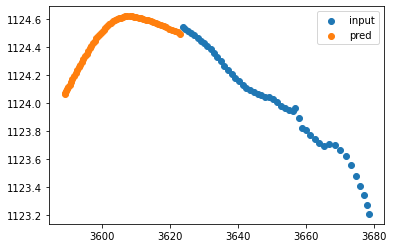

In [94]:
vis_test(20, True)

In [95]:
washington_array = make_pred(test_loader, batch_sz, washington_train_mod)
washington_array.shape

21


(3829, 120)

### palo-alto
- best KAGGLE val loss: 37.11707135793325
- best val loss: 23.354386381200843

In [97]:
# intialize a dataset
city = 'palo-alto' 
split = 'train' 
hidden_dim = 64 # 256
batch_size = 32
palo_train_mod, palo_losses = fit(city=city, split=split,
                                        hidden_dim=hidden_dim, batch_size=batch_size, num_iters=150)


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1
Training & Validating ----------------
- Training Loss: 189.87137542634053
- Validation Loss: 61.5089162878088
- Train Time: 2.12998366355896
- Elapsed Time: 2.168370008468628

Epoch 2
Training & Validating ----------------
- Training Loss: 68.65271600559133
- Validation Loss: 51.734536042084564
- Train Time: 3.723102569580078
- Elapsed Time: 3.7966954708099365

Epoch 3
Training & Validating ----------------
- Training Loss: 53.984677323247986
- Validation Loss: 40.02789497375488
- Train Time: 5.3143699169158936
- Elapsed Time: 5.4228503704071045

Epoch 4
Training & Validating ----------------
- Training Loss: 49.8145067345141
- Validation Loss: 40.839714875092376
- Train Time: 7.502635478973389
- Elapsed Time: 7.676073789596558

Epoch 5
Training & Validating ----------------
- Training Loss: 44.95579079421408
- Validation Loss: 39.495107805406725
- Train Time: 9.282348871231079
- Elapsed Time: 9.494992733001709

Epoch 6
Training & Validating ----------------
- Training Loss: 4

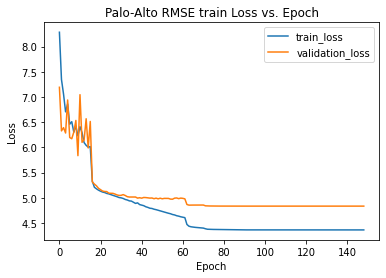

In [99]:
plot_loss(1, 'Palo-Alto', 'train', palo_losses)

torch.Size([32, 50, 2])
torch.Size([32, 60, 2])
torch.Size([32, 60, 2])


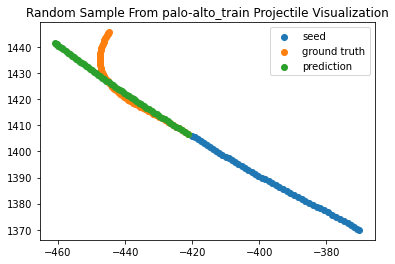

In [102]:
vis_results('palo-alto', 'train', 32, palo_train_mod, 2)

In [103]:
# intialize a dataset
city = 'palo-alto' 
split = 'test' 
test_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=True)
temp_dataset = ArgoverseDataset(city = city, split = split, transform=False, normalized=False)
print(len(test_dataset))

# test_dataset.start_pos

batch_sz = 32  # batch size 
test_loader = DataLoader(test_dataset, batch_size=batch_sz)
temp_loader = DataLoader(temp_dataset, batch_size=batch_sz)
palo_train_mod.to('cpu')
len(test_loader)

1686


53

22


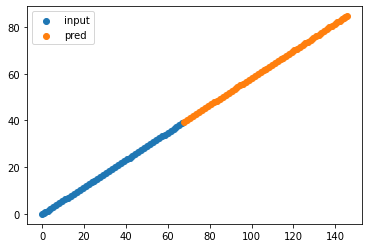

In [104]:
vis_test(21, False)

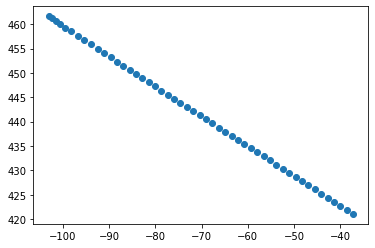

In [105]:
for X in temp_loader:
    if len(X) == batch_sz:
        continue
    # the index here should refer to the above cell's number
    plt.scatter(X[21, :, 0], X[21, :, 1], label='input')
    plt.legend
    plt.show()

22


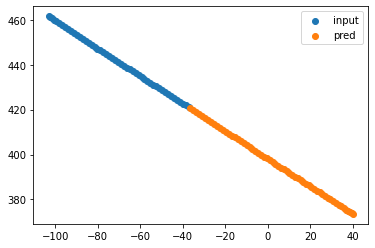

In [106]:
vis_test(21, True)

In [107]:
palo_array = make_pred(test_loader, batch_sz, palo_train_mod)
palo_array.shape

22


(1686, 120)

### Kaggle loss: 28.73365

## Write file
- austin_array 6325
- miami_array 7971
- pittsburgh_array 6361
- dearborn_array 3671
- washington_array 3829
- palo_array 1686

In [108]:
import csv

In [109]:
cols = [['ID'] + ['v{}'.format(i) for i in range(120)]]

with open('output.csv', 'w+') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(cols)

with open('output.csv', 'a') as file:
    mywriter = csv.writer(file, delimiter=',')
    
    count = 0
    for i in range(len(austin_array)):
        temp = [np.append(['{}_austin'.format(i)], austin_array[i])]
        mywriter.writerows(temp)
        count += 1
    print(count)
    
    count = 0
    for i in range(len(miami_array)):
        temp = [np.append(['{}_miami'.format(i)], miami_array[i])]
        mywriter.writerows(temp)
        count += 1
    print(count)
    
    count = 0
    for i in range(len(pittsburgh_array)):
        temp = [np.append(['{}_pittsburgh'.format(i)], pittsburgh_array[i])]
        mywriter.writerows(temp)
        count += 1
    print(count)
    
    count = 0
    for i in range(len(dearborn_array)):
        temp = [np.append(['{}_dearborn'.format(i)], dearborn_array[i])]
        mywriter.writerows(temp)
        count += 1
    print(count)
    
    count = 0
    for i in range(len(washington_array)):
        temp = [np.append(['{}_washington-dc'.format(i)], washington_array[i])]
        mywriter.writerows(temp)
        count += 1
    print(count)
    
    count = 0
    for i in range(len(palo_array)):
        temp = [np.append(['{}_palo-alto'.format(i)], palo_array[i])]
        mywriter.writerows(temp)
        count += 1
    print(count)
    

6325
7971
6361
3671
3829
1686
